<a href="https://colab.research.google.com/github/JinXianWen95/PyTorch-bootcamp/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this once and wait for the "Restart Session" notification
#!pip install "numpy<2.0" torchmetrics mlxtend -U

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# 1. Create a folder in your Drive for Copilot data if it doesn't exist
drive_path = "/content/drive/MyDrive/colab_copilot_data"
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# 2. Link the internal config directory to your Drive folder
# Note: Most Copilot data in Colab is stored under ~/.config/github-copilot
internal_config = "/root/.config/github-copilot"

# If the internal folder already exists (e.g., after login), remove it to make room for the link
if os.path.exists(internal_config) and not os.path.islink(internal_config):
    !rm -rf {internal_config}

# Create the symlink
!ln -s {drive_path} {internal_config}

print("Copilot data is now linked to your Google Drive.")

ln: failed to create symbolic link '/root/.config/github-copilot/colab_copilot_data': File exists
Copilot data is now linked to your Google Drive.


# PyTorch Computer Vision

* Reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that we can leverage for the specific problem
* `torchvision.transforms` - functions for manipulating the vision data (images) to be suitable for use with a ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.Dataloader` - Creates a Python iterable over a dataset

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="drive/MyDrive/colab_copilot_data/data", # where to download the data to
    train=True, # do we need the train dataset
    download=True,
    transform=ToTensor(),
    target_transform=None # how do we want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root="drive/MyDrive/colab_copilot_data/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

### 1.1 Input and output shapes of the data

In [ ]:
# Some data information
print(f'Train and Test Dataset dimensions: {len(train_data)}, {len(test_data)}')
print(f'Training sample: {train_data[0]}')
print(f'Target classes: {train_data.classes}')
print(f'Target class index: {train_data.class_to_idx}')
print(f'Train data labels: {train_data.targets}')

print(f'Image shape: {train_data[0][0].shape} -> [color, height, width]') # grayscale has only one channel
print(f'Image Label: {train_data.classes[train_data[0][1]]}')

Train and Test Dataset dimensions: 60000, 10000
Training sample: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,

### 1.2 Visualizing the data

(-0.5, 27.5, 27.5, -0.5)

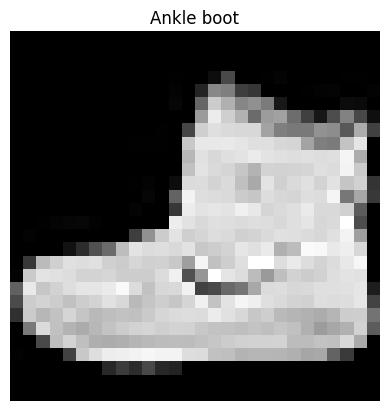

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)

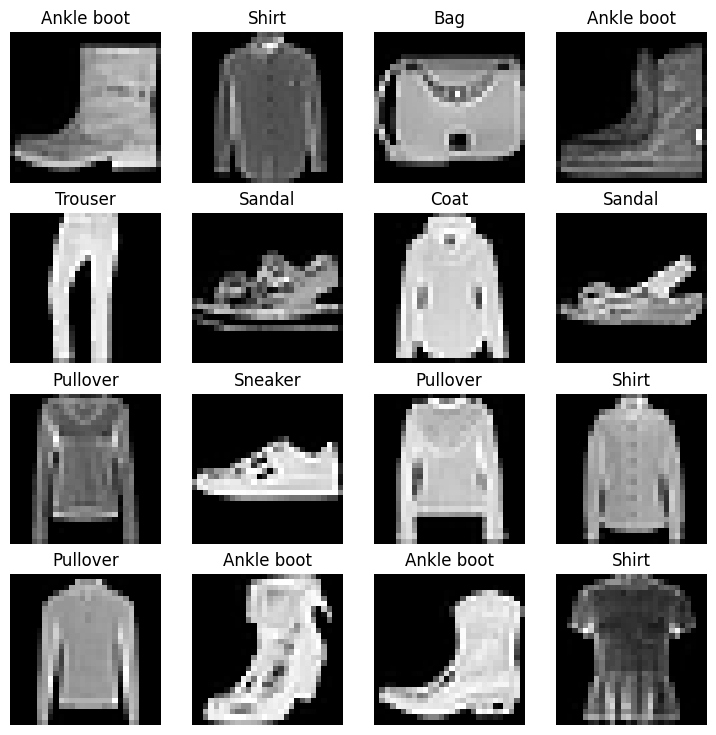

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False)

Do you think these items of clothing could be modelled with pure linear lines?

## 2. Prepare DataLoader
Right now, the data is in the form of PyTorch Datasets.

DataLoader turns the dataset into a Python iterable.

More specifically, we want to turn the data into batches(or mini-batches).

Why would we do this?

1. It's more computationally efficient, as the computing hardware may not be able to look (store in memeory) at 60000 images in one hit. So we break it down to 32 images at time (mini-batch of 32)

2. It gives the neural network more chances to update its gradient per epoch (mini-batch gradient descent)

In [ ]:
print(train_data, test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: drive/MyDrive/colab_copilot_data/data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: drive/MyDrive/colab_copilot_data/data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
from torch.utils.data import DataLoader

# Setup the bacth size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # in case the dataset has an order

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

# Let's check out the data
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} items...')
print(f'Length of train dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} items...')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d865c27fc20>, <torch.utils.data.dataloader.DataLoader object at 0x7d866c08b0b0>)
Length of train dataloader: 1875 batches of 32 items...
Length of train dataloader: 313 batches of 32 items...


torch.Size([32, 1, 28, 28]) torch.Size([32])
Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


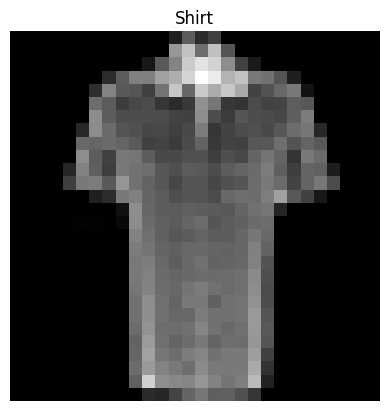

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)

print(f'Image size: {image.shape}')
print(f'Label: {label}, label size: {label.shape}')

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model we will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # forward pass

print(f'Shape before flattening: {x.shape} -> [color, height, width]')
print(f'Shape after flattening: {output.shape} -> [color, height*width]')

Shape before flattening: torch.Size([1, 28, 28]) -> [color, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color, height*width]


We've now turned our pixel data from height and width dimensions into one long feature vector.

And nn.Linear() layers like their inputs to be in the form of feature vectors.

In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(train_data.classes)).to("cpu")

print(model_0)

dummy_x = torch.rand([1, 1, 28, 28])
print(model_0(dummy_x)) # output 10 logits
print(model_0.state_dict())

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)
tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)
OrderedDict({'layer_stack.1.weight': tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]]), 'layer_stack.1.bias': tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
         0.0018,  0.0163]), 'layer_stack.2.weight': tensor([[ 0.0614, -

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, the loss function will be `nnCrossEntropyLoss()`
* Optimizer = `torch.optim.SGD()`
* Evaluation metric - since we're working on classification problem and the dataset is balanced, let's use accuracy.

In [ ]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("File helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

File helper_functions.py already exists, skipping download


In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Create a function to time the experimets.

Machine learning is very experimental.

Two of the main things to tacke are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f'Train time on {device}: {total_time: .3f} seconds')
  return total_time

In [ ]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start_time, end_time, "cpu")

Train time on cpu:  0.000 seconds


3.461799997239723e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Lopp through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculates the test loss *per vatch*
4. Print out what's happening
5. Time it all

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')

  ### Training
  train_loss = 0
  # Add a loop to loop though the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for (X_test, y_test) in test_dataloader:
      # Forward pass
      test_pred = model_0(X_test)

      # Loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Test loss average per batch
    test_loss /= len(test_dataloader)

    # Test accuracy average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f'\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

  # Calculate training time
  train_time_end_on_cpu = timer()
  total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                             train_time_end_on_cpu,
                                             str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.04%
Train time on cpu:  9.869 seconds
Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.20%
Train time on cpu:  18.665 seconds
Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.43%
Train time on cpu:  28.330 seconds


## 4. Make predictions and get model results

In [ ]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only when the model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model_0 results
model_0_results = eval_model(
    model_0,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    "cpu"
)

print(model_0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663888335227966, 'model_acc': 83.42651757188499}


## 5. Setup device agnostic-code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 6. Model 1: Building a better model with non-linearity

We learn the power of non-linearity in notebook 02

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

model_1 = FashionMNISTModelV1(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

### 6.1 Functionizing training and evaluation metrics

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
    ):
  """Performs a training loop with model trying to learn on data_loader"""

  model.to(device)
  model.train()

  ### Training
  train_loss, train_acc = 0, 0
  # Add a loop to loop though the training batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f'Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%')

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):
  """Performs a test loop stesp on model over dataloader"""
  test_loss, test_acc = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for (X_test, y_test) in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      test_pred = model(X_test)

      # Loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Test loss average per batch
    test_loss /= len(dataloader)

    # Test accuracy average per batch
    test_acc /= len(dataloader)

  # Print out what's happening
  print(f'Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

In [ ]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')

  train_step(
    model=model_1,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn
  )

  test_step(
    model=model_1,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
  )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu,
                                             train_time_end_on_gpu,
                                             str(next(model_1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.08243, Train acc: 63.03%
Test loss: 0.96598, Test acc: 66.16%
Epoch: 1
------
Train loss: 0.91958, Train acc: 67.34%
Test loss: 0.92200, Test acc: 67.78%
Epoch: 2
------
Train loss: 0.89581, Train acc: 67.89%
Test loss: 0.92112, Test acc: 68.02%
Train time on cuda:0:  35.662 seconds


**Note:** Sometimes, depending on the data/hardware we could find that the model trains faster on CPU than GPU/

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware we're using has a better CPU in terms of computing capability than the GPU

In [ ]:
print(model_0_results)

model_1_results = eval_model(
    model_1,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    device
)

print(model_1_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663888335227966, 'model_acc': 83.42651757188499}


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.9211227893829346, 'model_acc': 68.02116613418531}


## Model 2: Building a Convolutional Neural Network (CNN)

CNN's also known as ConvNets and are known for their capabilities to find patterns in visual data.

Resource: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, # 2d because we have height and width
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # Pass a tensor through the cnn and use print to find out the shape of 7*7
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f'Output shape of cov_block_1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of cov_block_2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1, # we have only one color channel
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)
print(model_2)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


### 7.1 Stepping through `nn.Conv2d()`

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test image:\n {test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3, # equivalent (3, 3)
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
print(conv_output.shape)

torch.Size([10, 62, 62])


### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
# Print out original image shape
print(f'Test image original shape: {test_image.shape}')

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f'Shape after conv_layer: {test_image_through_conv.shape}')

# Pass data through the max_pool_layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Shape after conv and max_pool layers: {test_image_through_conv_and_max_pool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Shape after conv_layer: torch.Size([10, 62, 62])
Shape after conv and max_pool layers: torch.Size([10, 31, 31])


In [ ]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f'\nrandom_tensor:\n{random_tensor}')
print(f'\nrandom_tensor shape:\n{random_tensor.shape}')

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f'\nmax pool tensor:\n{max_pool_tensor}')
print(f'\nmax pool tensor shape:\n{max_pool_tensor.shape}')


random_tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

random_tensor shape:
torch.Size([1, 1, 2, 2])

max pool tensor:
tensor([[[[0.3367]]]])

max pool tensor shape:
torch.Size([1, 1, 1, 1])


torch.Size([1, 28, 28])


tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

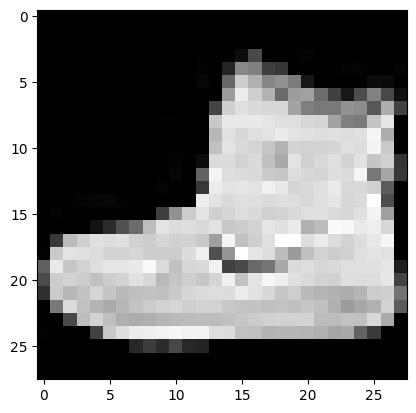

In [ ]:
print(image.shape)
plt.imshow(image.squeeze(), cmap="gray")

model_2(image.unsqueeze(0).to(device)) # the model requires BCHW

### 7.3 Setup Loss function and optimizer for `model2`

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and testing `model_2` using training and testing functions

In [ ]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu_model_2 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')

  train_step(
    model=model_2,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn
  )

  test_step(
    model=model_2,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
  )

train_time_end_on_gpu_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_on_gpu_model_2,
                                             train_time_end_on_gpu_model_2,
                                             str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59679, Train acc: 78.30%
Test loss: 0.40210, Test acc: 85.48%
Epoch: 1
------
Train loss: 0.36245, Train acc: 86.92%
Test loss: 0.35373, Test acc: 86.92%
Epoch: 2
------
Train loss: 0.32535, Train acc: 88.20%
Test loss: 0.32523, Test acc: 88.20%
Train time on cuda:0:  36.910 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model_2,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    device
)

  0%|          | 0/313 [00:00<?, ?it/s]

## 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
print(compare_results)

            model_name  model_loss  model_acc
0  FashionMNISTModelV0    0.476639  83.426518
1  FashionMNISTModelV1    0.921123  68.021166
2  FashionMNISTModelV2    0.325232  88.198882


In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]

print(compare_results)

            model_name  model_loss  model_acc  training_time
0  FashionMNISTModelV0    0.476639  83.426518      28.329518
1  FashionMNISTModelV1    0.921123  68.021166      35.662448
2  FashionMNISTModelV2    0.325232  88.198882      36.909760


Text(0.5, 0, 'accuracy %')

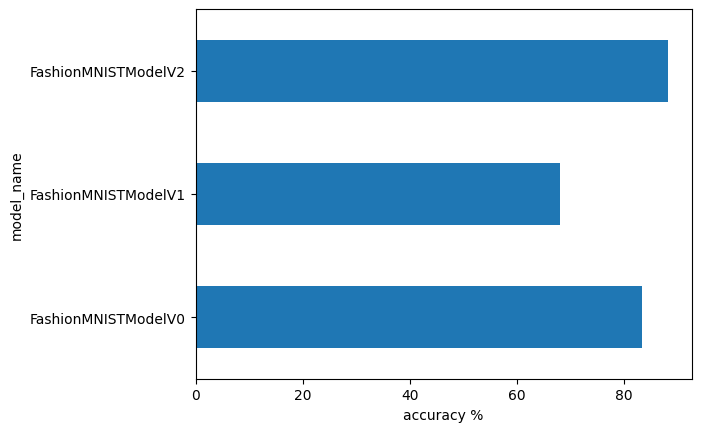

In [ ]:
# Visualize the model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy %")

## 9. Make and evaluate random predictions iwth the best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prod = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred prod off the GPU for further calculations
      pred_probs.append(pred_prod.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)


torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Dress')

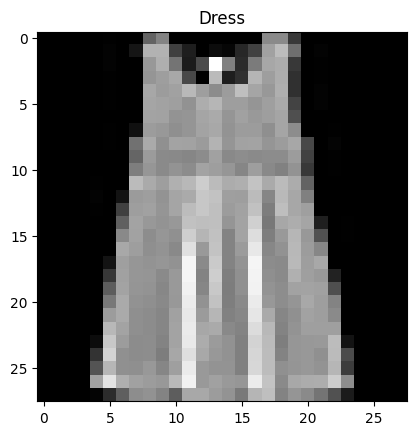

In [ ]:
import random

#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9): # 9 samples
  test_samples.append(sample)
  test_labels.append(label)

print(test_samples[0].shape)
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(test_data.classes[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)

print(torch.eq(pred_classes, torch.tensor(test_labels)))

tensor([ True,  True, False,  True, False,  True,  True,  True, False])


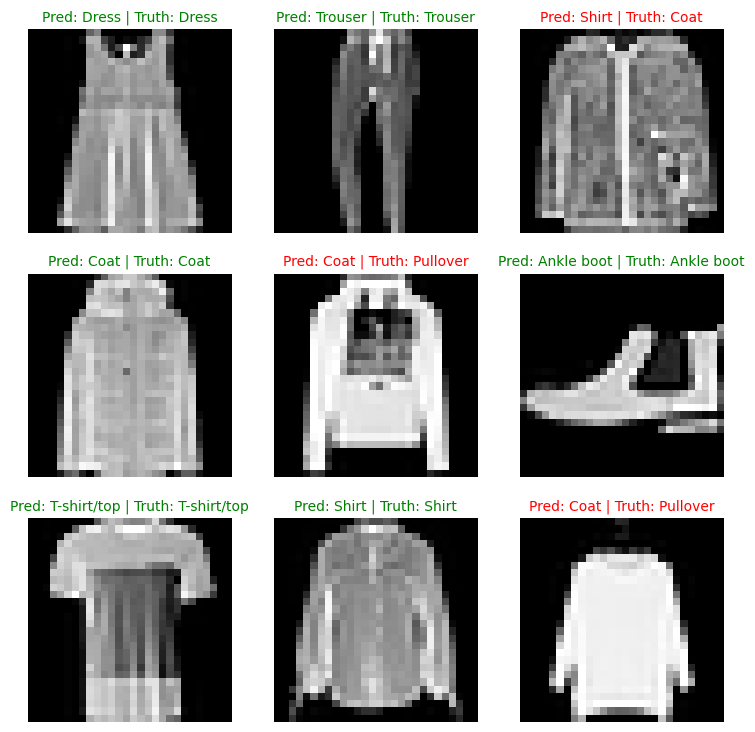

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = test_data.classes[pred_classes[i]]
  truth_label = test_data.classes[test_labels[i]]

  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  # Check the equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a way of evaluating the classification models

1. Make predictions with the trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix()`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
from tqdm.auto import tqdm

# 1. Make predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1) # batch of 32 items
    y_preds.append(y_pred.cpu())

  # Concatenate list of predictions into a tensor
  print(y_preds[:2])
  y_pred_tensor = torch.cat(y_preds)
  print(len(y_pred_tensor))

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 9, 6, 7, 2, 1, 4, 6, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5])]
10000


In [ ]:
import numpy as np
import mlxtend
import torchmetrics

# Verify versions
print(f"NumPy version: {np.__version__}")       # Should be 1.26.x
print(f"Mlxtend version: {mlxtend.__version__}") # Should be 0.24.x

NumPy version: 1.26.4
Mlxtend version: 0.23.4


tensor([[643,   6,  47,  81,  12,   0, 199,   0,  11,   1],
        [  9, 886,   4,  73,  21,   0,   5,   0,   2,   0],
        [  9,   3, 790,  11, 108,   0,  72,   0,   7,   0],
        [ 26,  12,  33, 856,  36,   0,  28,   0,   7,   2],
        [  6,   6, 113,  44, 722,   0, 104,   0,   5,   0],
        [ 11,   1,   8,  10,   1, 815,   3,  56,  69,  26],
        [ 76,   6, 122,  67,  90,   0, 631,   0,   8,   0],
        [  1,   2,   0,   0,   0,  25,   0, 901,  12,  59],
        [ 13,   2,  18,  15,  11,   7,  36,   7, 890,   1],
        [  0,   0,   1,   3,   0,  24,   2,  74,   5, 891]])


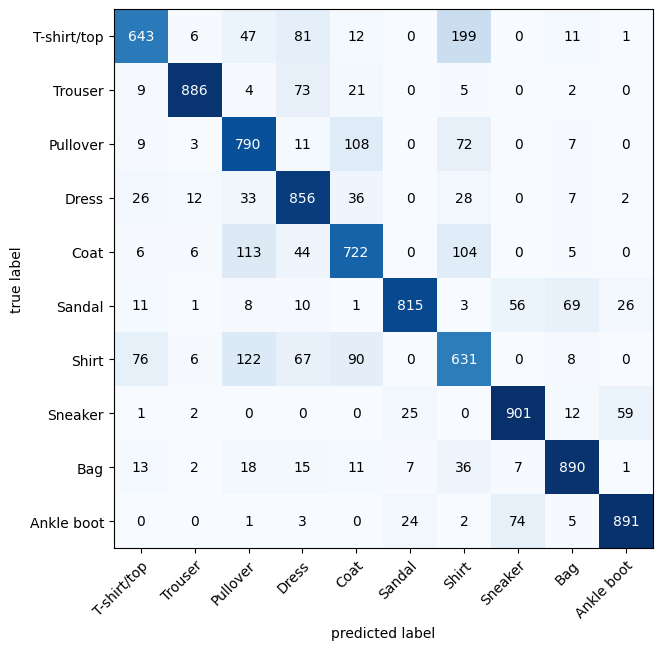

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(test_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
print(confmat_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with numpy
    class_names=test_data.classes,
    figsize=(10,7)
)

## 11. Save and load the best performing model

In [ ]:
# Save
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("drive/MyDrive/colab_copilot_data/models/03_computer_vision/cnn")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "03_pytorch_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)
print(f'Saved successfully')

Saving model to: drive/MyDrive/colab_copilot_data/models/03_computer_vision/cnn/03_pytorch_cnn_model.pth
Saved successfully


In [ ]:
# Load
# Instantiate a fresh instance of FashionMNISTModelV2
loaded_model_2 = FashionMNISTModelV2(
    input_shape=1, # we have only one color channel
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

# Load model state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_2.to(device)

print(f"Loaded model:\n{loaded_model_2}")
print(f"Model on device:\n{next(loaded_model_2.parameters()).device}")

Loaded model:
FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_2_results = eval_model(
    loaded_model_2,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    device
)
print(loaded_model_2_results)
print(model_2_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3252318501472473, 'model_acc': 88.19888178913737}
{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3252318501472473, 'model_acc': 88.19888178913737}


In [ ]:
# Check if model results are close
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02 # tolerance
              )

tensor(True)

## Exercise

### 5. Load the `torchvision.datasets.MNIST()` train and test datasets.

In [ ]:
# Setup training data
train_data = datasets.MNIST(
    root="drive/MyDrive/colab_copilot_data/data", # where to download the data to
    train=True, # do we need the train dataset
    download=True,
    transform=ToTensor(),
    target_transform=None # how do we want to transform the labels/targets
)

test_data = datasets.MNIST(
    root="drive/MyDrive/colab_copilot_data/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

### 6. Visualize at least 5 different samples of the MNIST training dataset.

Train and Test Dataset dimensions: 60000, 10000
Training sample: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

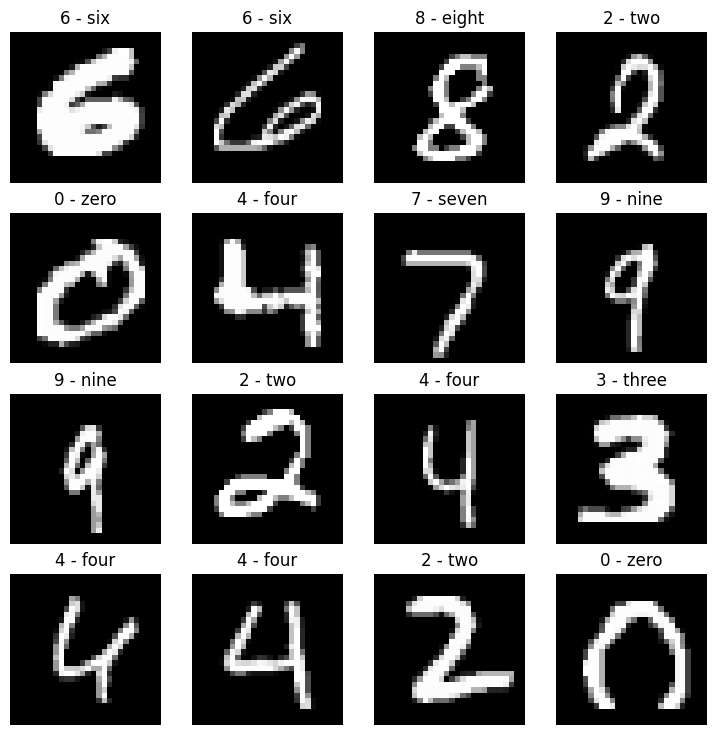

In [ ]:
print(f'Train and Test Dataset dimensions: {len(train_data)}, {len(test_data)}')
print(f'Training sample: {train_data[0]}')
print(f'Target classes: {train_data.classes}')
print(f'Target class index: {train_data.class_to_idx}')
print(f'Train data labels: {train_data.targets}')

print(f'Image shape: {train_data[0][0].shape} -> [color, height, width]') # grayscale has only one channel
print(f'Image Label: {train_data.classes[train_data[0][1]]}')

image, label = train_data[0]

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False)

### 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # in case the dataset has an order

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

# Let's check out the data
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} items...')
print(f'Length of train dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} items...')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d865c059880>, <torch.utils.data.dataloader.DataLoader object at 0x7d865c27fc20>)
Length of train dataloader: 1875 batches of 32 items...
Length of train dataloader: 313 batches of 32 items...


### 8. Recreate model_2 used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
# Create a convolutional neural network
class MNISTModelV3(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, # 2d because we have height and width
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # Pass a tensor through the cnn and use print to find out the shape of 7*7
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f'Output shape of cov_block_1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of cov_block_2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x

model_3 = MNISTModelV3(
    input_shape=1,
    hidden_units=64,
    output_shape=len(train_data.classes))

### 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu_model_3 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')

  train_step(
    model=model_3,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    device='cuda:0'
  )

  test_step(
    model=model_3,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device='cuda:0'
  )

train_time_end_on_gpu_model_3 = timer()
total_train_time_model_3 = print_train_time(train_time_start_on_gpu_model_3,
                                             train_time_end_on_gpu_model_3,
                                             str(next(model_3.parameters()).device))

model_3_results = eval_model(
    model_3,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    'cuda:0'
)
print(model_3_results)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.18959, Train acc: 93.87%
Test loss: 0.05163, Test acc: 98.35%
Epoch: 1
------
Train loss: 0.04971, Train acc: 98.46%
Test loss: 0.03863, Test acc: 98.83%
Epoch: 2
------
Train loss: 0.03511, Train acc: 98.91%
Test loss: 0.03933, Test acc: 98.79%
Train time on cuda:0:  40.621 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTModelV3', 'model_loss': 0.039327993988990784, 'model_acc': 98.79193290734824}


In [ ]:
model_4 = MNISTModelV3(
    input_shape=1,
    hidden_units=10,
    output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu_model_4 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')

  train_step(
    model=model_4,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    device='cpu'
  )

  test_step(
    model=model_4,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device='cpu'
  )

train_time_end_on_cpu_model_4 = timer()
total_train_time_model_3 = print_train_time(train_time_start_on_cpu_model_4,
                                             train_time_end_on_cpu_model_4,
                                             str(next(model_4.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.41768, Train acc: 85.50%
Test loss: 0.07185, Test acc: 97.75%
Epoch: 1
------
Train loss: 0.07969, Train acc: 97.52%
Test loss: 0.06110, Test acc: 97.98%
Epoch: 2
------
Train loss: 0.06195, Train acc: 98.09%
Test loss: 0.05232, Test acc: 98.34%
Train time on cpu:  115.545 seconds


### 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

tensor([True, True, True, True, True, True, True, True, True])
[tensor([7, 2, 1, 0, 8, 1, 8, 8, 8, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        8, 0, 7, 4, 0, 1, 3, 1]), tensor([3, 4, 7, 2, 7, 1, 0, 1, 1, 7, 4, 1, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0,
        4, 1, 9, 5, 7, 8, 9, 3])]
10000


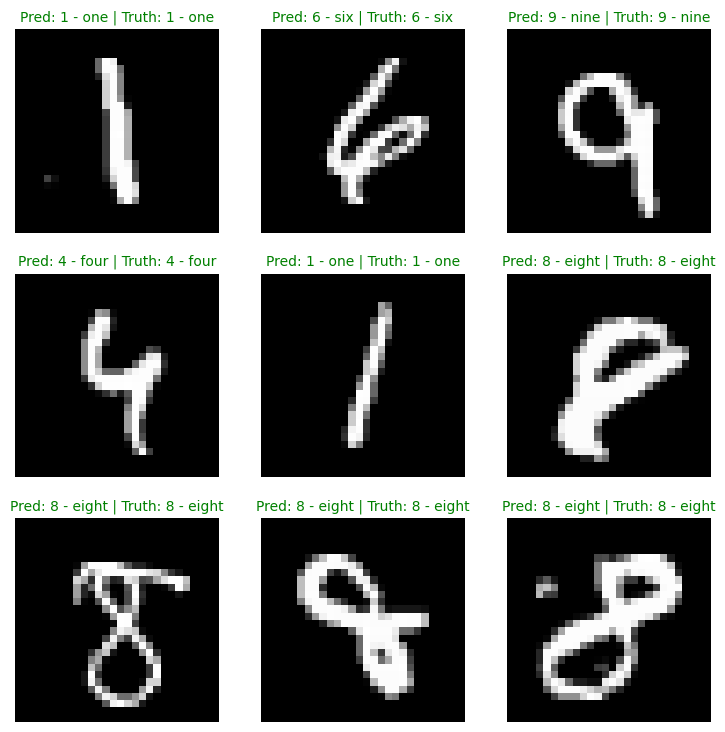

In [ ]:
# Make predictions
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9): # 9 samples
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model_3,
                              data=test_samples)

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)

print(torch.eq(pred_classes, torch.tensor(test_labels)))
# Concatenate list of predictions into a tensor
print(y_preds[:2])
y_pred_tensor = torch.cat(y_preds)
print(len(y_pred_tensor))

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = test_data.classes[pred_classes[i]]
  truth_label = test_data.classes[test_labels[i]]

  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  # Check the equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([[ 951,    3,    3,    0,    1,    2,    9,    2,    7,    2],
        [   0, 1127,    0,    0,    4,    0,    4,    0,    0,    0],
        [  19,  110,  839,   12,    3,    1,    2,   19,   27,    0],
        [   5,   15,    6,  908,    4,   40,    1,   14,   11,    6],
        [   5,   11,    0,    0,  924,    2,    9,    6,    6,   19],
        [   4,    4,    1,   12,    2,  807,   17,    8,   16,   21],
        [   6,    8,    0,    0,    2,   16,  916,    0,   10,    0],
        [   3,   43,   14,   11,    3,    5,    0,  922,    3,   24],
        [   8,    5,    5,    4,    5,   11,    4,    2,  927,    3],
        [   6,    9,    2,    4,   26,    5,    2,   14,   14,  927]])


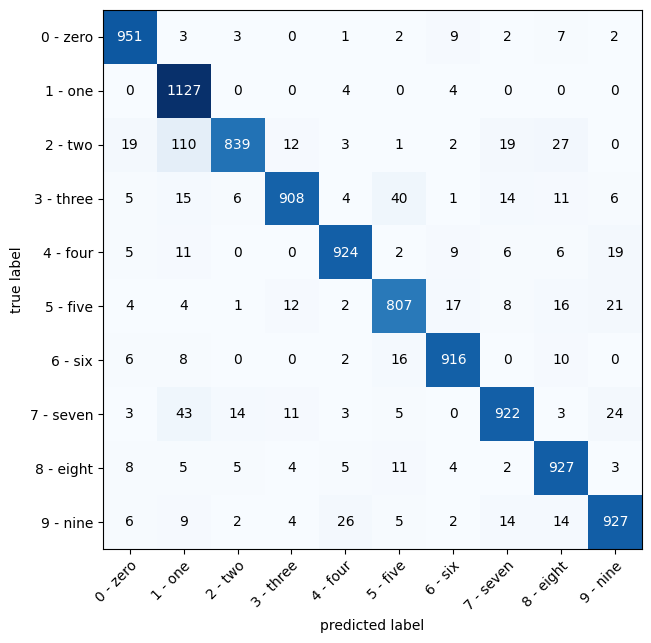

In [ ]:
# 1. Make predictions
y_preds = []
model_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)

    y_logit = model_3(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1) # batch of 32 items
    y_preds.append(y_pred.cpu())

# 2. setup confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(test_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
print(confmat_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with numpy
    class_names=test_data.classes,
    figsize=(10,7))